## Time Series and Stock Market
Для начала импортируем нужные библеотеки и функции 

In [264]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
import requests
import json
import seaborn as sns

Далее загрузим данные с помощью API

In [319]:
STOCK_URL = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={}&interval=1min&outputsize=full&apikey=U4GRLAENS28R6K1H'

stock = 'BA'
r = requests.get(STOCK_URL.format(stock))
print(r.json()['Meta Data'])
stock_info = pd.DataFrame(data=r.json()['Time Series (1min)']).T
stock_info = stock_info.reset_index().sort_values(by=['index']).reset_index()
stock_info['4. close'] = stock_info['4. close'].astype('float')
stock_info = stock_info.drop(columns=['level_0', '1. open', '2. high', '3. low', '5. volume'])

{'1. Information': 'Intraday (1min) open, high, low, close prices and volume', '2. Symbol': 'BA', '3. Last Refreshed': '2020-09-25 20:00:00', '4. Interval': '1min', '5. Output Size': 'Full size', '6. Time Zone': 'US/Eastern'}


In [320]:
test_index = 300

data = stock_info.head(test_index)
data

,index,4. close
0,2020-09-14 04:01:00,163.0000
1,2020-09-14 04:03:00,162.4700
2,2020-09-14 04:05:00,163.0000
3,2020-09-14 04:08:00,162.9600
4,2020-09-14 04:19:00,162.9600
...,...,...
295,2020-09-14 12:50:00,164.2065
296,2020-09-14 12:51:00,164.2800
297,2020-09-14 12:52:00,164.4913
298,2020-09-14 12:53:00,164.4800


In [321]:
data.dtypes

index        object
4. close    float64
dtype: object

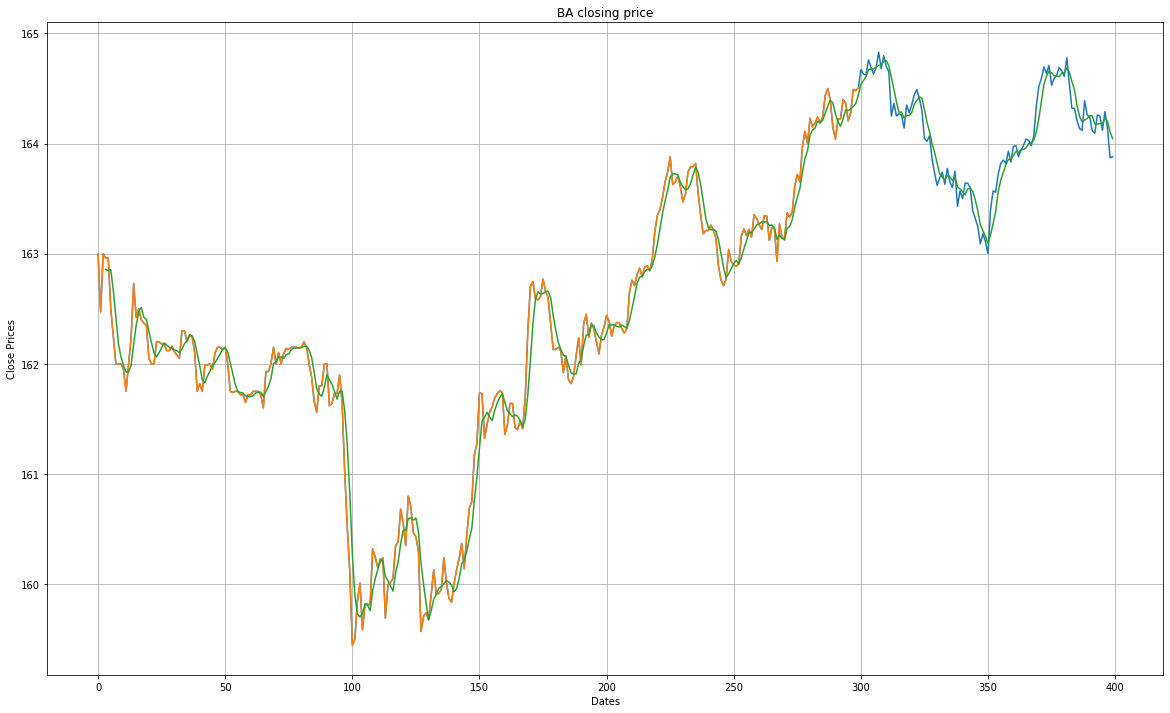

In [339]:
plt.figure(figsize=(20, 12))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
#plt.plot(data['index'], data['4. close'])
plt.plot(stock_info.head(400)['4. close'])
plt.plot(data['4. close'])
plt.plot(stock_info.head(400)['4. close'].rolling(4).mean())
plt.title('{} closing price'.format(stock))

plt.show()

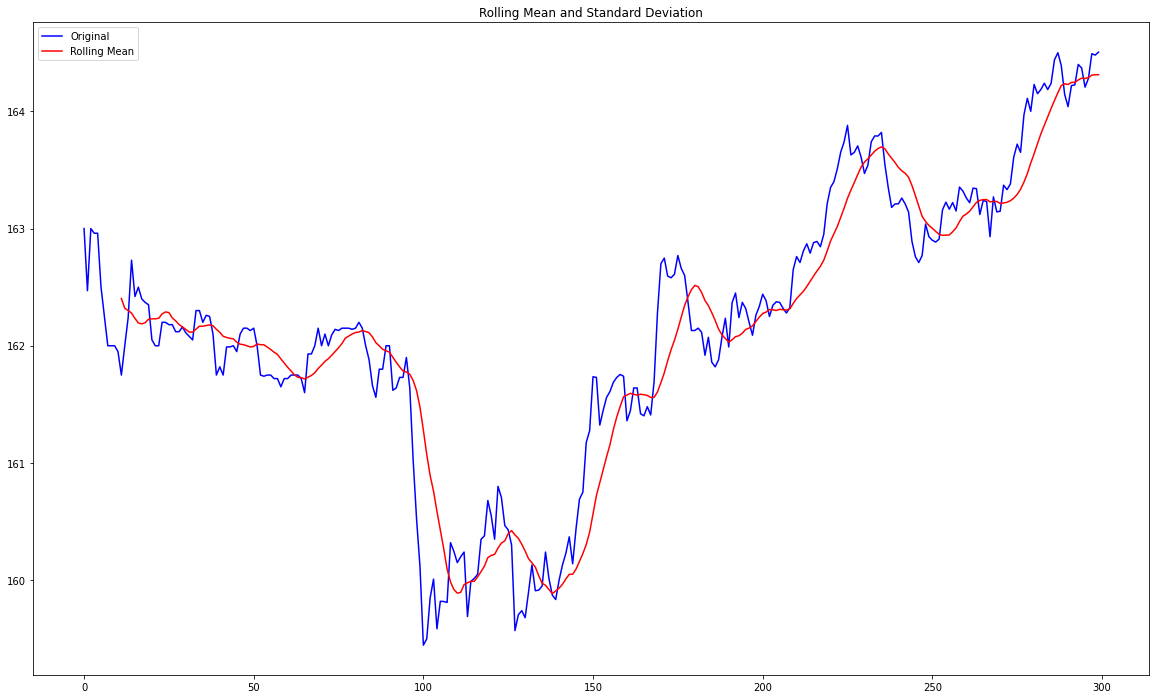

Results of dickey fuller test
Test Statistics                 -0.865988
p-value                          0.798967
No. of lags used                 4.000000
Number of observations used    295.000000
critical value (1%)             -3.452713
critical value (5%)             -2.871388
critical value (10%)            -2.572017
dtype: float64


In [323]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(20, 12))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    #plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(data['4. close'])

0      1.000769
1      1.000485
2      1.000448
3      1.000550
4      1.000432
         ...   
295    1.000216
296    0.999972
297    0.999882
298    1.000090
299    1.000533
Name: seasonal, Length: 300, dtype: float64


<Figure size 432x288 with 0 Axes>

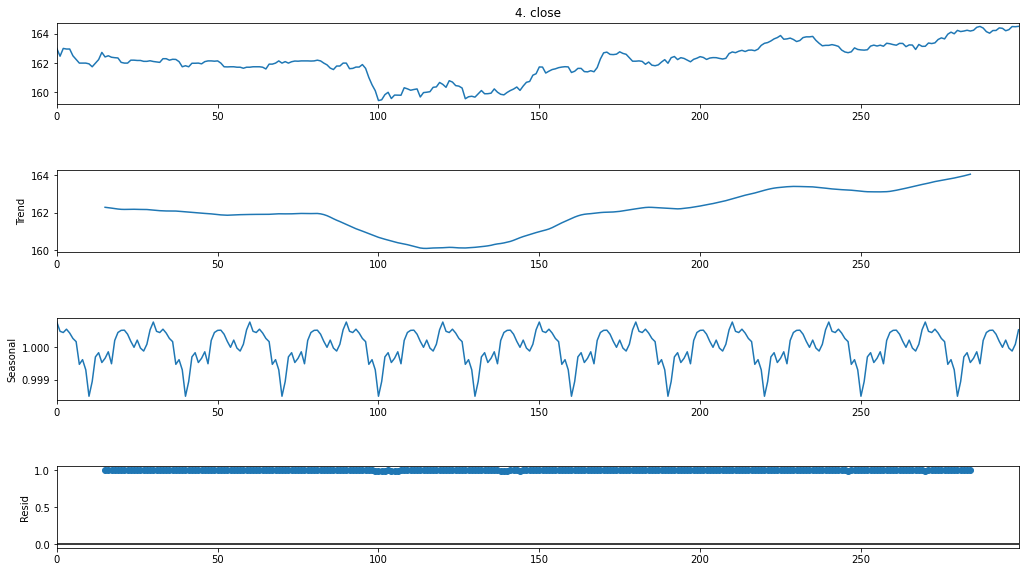

In [324]:
result = seasonal_decompose(data['4. close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)
print(result.seasonal)

In [325]:
data = stock_info.head(test_index)
print(data.shape, stock_info.shape)

(300, 2) (6511, 2)


In [328]:
average_par = 5
def mean_forecast(df, delay):
    return df.tail(average_par).mean()['4. close']


def latency_analysis(forecast_func, delay_range):
    profit_delay = []
    delay_range = 40

    for delay in range(delay_range):
        #print(delay, profit_delay)
        data = stock_info.head(test_index)
        profit = 0
        
        open_pos = False
        price = -1
        a = 0
        b = 0
        c = 0
        num = 0

        while data.shape[0] < stock_info.shape[0] - delay:
            stock_std = data.tail(average_par)['4. close'].std()
            forecast = forecast_func(data, delay)
            cur_price = stock_info['4. close'][data.shape[0] + delay]

            if not open_pos:
                if cur_price < forecast - stock_std:
                    open_pos = True
                    profit -= cur_price
                    price = cur_price
            else:
                if cur_price > forecast + 3 * stock_std:
                    open_pos = False
                    profit += cur_price
                    a += 1
                elif cur_price < price - stock_std:
                    open_pos = False
                    profit += cur_price
                    b += 1
                elif cur_price > price + stock_std:
                    open_pos = False
                    profit += cur_price
                    c += 1

            data = stock_info.head(data.shape[0] + delay + 1)
            num += 1
        #print(a, b, c, num)
        profit += cur_price * int(open_pos)
        profit_delay.append(profit)

    print(profit_delay)
    plt.figure(figsize=(20, 12))
    plt.grid(True)
    plt.plot(profit_delay)        
    plt.show()

Проверим результат, полученный на основе предсказаний с помощью среднего за последние несколько измерений

[21.730299999999602, 0.52509999999981, -9.658499999999947, -2.650200000000268, -0.23329999999998563, -0.1010999999998603, 5.156399999999849, 0.6984999999999673, 4.016700000000185, 0.32269999999985544, 5.988700000000051, -0.7415000000000305, 4.101300000000151, -2.5424999999999613, -10.933299999999974, -4.771300000000082, 1.138800000000117, 9.262700000000109, 1.9073000000002764, -2.127299999999906, -0.8492999999999711, -1.3105999999999938, 9.26210000000006, 8.02190000000013, -0.9847999999998933, -2.446600000000018, 1.4055000000001598, -4.994100000000003, -2.199500000000171, 1.1429000000000826, -2.665900000000107, -2.8183999999999685, -0.3033999999999537, -2.755900000000196, -0.031899999999978945, 3.5931000000001063, -1.4322000000001083, 2.14020000000005, 2.988500000000016, 4.537199999999956]


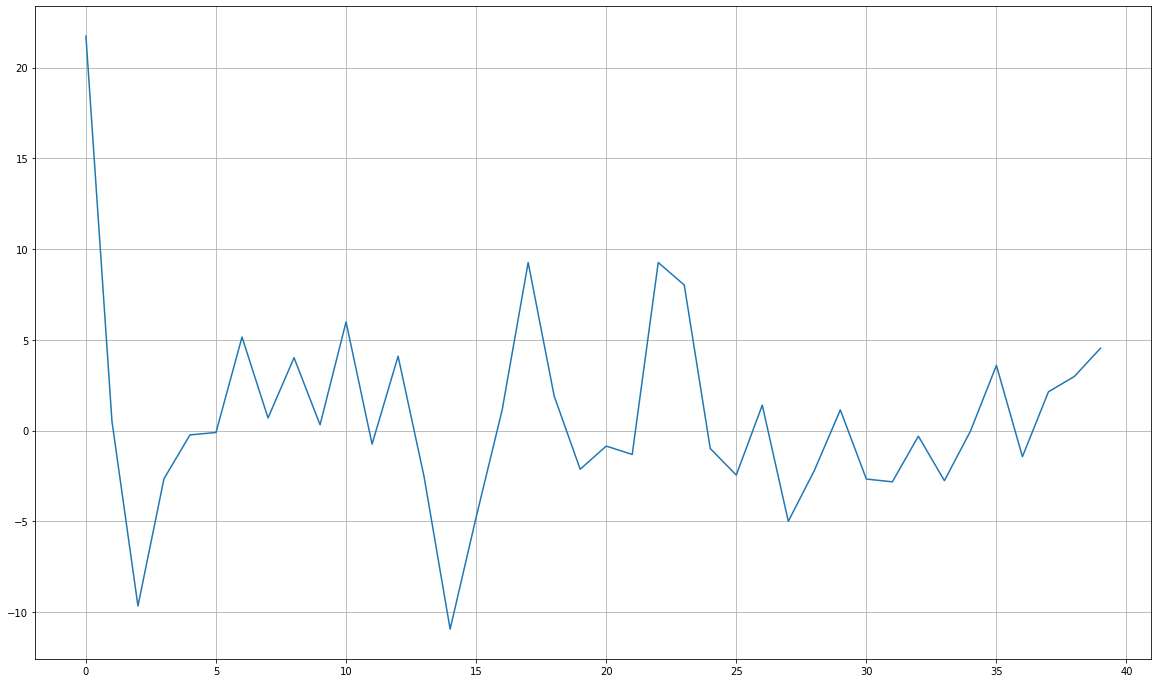

In [329]:
latency_analysis(mean_forecast, 40)

Далее попробуем применить модель Экспоненциального сглаживания

In [307]:
data = stock_info.head(test_index)

seas_periods = -1
mse = 10 ** 10
for seas_p in range(2, 50):
    model = ExponentialSmoothing(data.head(test_index - 30)['4. close'], trend='add', seasonal='add', seasonal_periods=seas_p)
    fit = model.fit()
    pred = fit.forecast(30)
    error = math.sqrt(mean_squared_error(data.tail(30)['4. close'], pred))
    if error < mse:
        mse = error
        seas_periods = seas_p
print(seas_periods, mse)

44 0.027815733937885122


In [301]:
def exp_sm_forecasting(df, delay):
    model = ExponentialSmoothing(df.tail(100)['4. close'], trend='mul', seasonal='mul', seasonal_periods=seas_periods)
    fit = model.fit()
    pred = fit.forecast(delay + 1).reset_index()
    return float(pred.tail(1)[0])

0 []
1 [6.512699999999853]
2 [6.512699999999853, -0.4960999999998279]
3 [6.512699999999853, -0.4960999999998279, -0.66809999999996]
4 [6.512699999999853, -0.4960999999998279, -0.66809999999996, -0.1471000000001652]
5 [6.512699999999853, -0.4960999999998279, -0.66809999999996, -0.1471000000001652, 1.416799999999995]
6 [6.512699999999853, -0.4960999999998279, -0.66809999999996, -0.1471000000001652, 1.416799999999995, -0.6166000000000196]
7 [6.512699999999853, -0.4960999999998279, -0.66809999999996, -0.1471000000001652, 1.416799999999995, -0.6166000000000196, 0.8649999999999807]
8 [6.512699999999853, -0.4960999999998279, -0.66809999999996, -0.1471000000001652, 1.416799999999995, -0.6166000000000196, 0.8649999999999807, -1.3216999999999857]
9 [6.512699999999853, -0.4960999999998279, -0.66809999999996, -0.1471000000001652, 1.416799999999995, -0.6166000000000196, 0.8649999999999807, -1.3216999999999857, 0.819700000000033]
10 [6.512699999999853, -0.4960999999998279, -0.66809999999996, -0.1471

29 [6.512699999999853, -0.4960999999998279, -0.66809999999996, -0.1471000000001652, 1.416799999999995, -0.6166000000000196, 0.8649999999999807, -1.3216999999999857, 0.819700000000033, -1.046400000000041, 1.0744999999999578, -1.7002000000000308, -0.05590000000002249, -0.2708999999999975, -1.6008000000000067, -0.4123999999999626, -0.1537999999999471, -0.8566999999999609, -0.3682999999999481, -0.43139999999997514, 0.7041000000000253, -0.9271000000000029, 1.5098000000000127, 0.7234999999999943, 1.5067000000000093, -0.4309000000000154, -0.048100000000040666, -0.7119, -0.873000000000026]
30 [6.512699999999853, -0.4960999999998279, -0.66809999999996, -0.1471000000001652, 1.416799999999995, -0.6166000000000196, 0.8649999999999807, -1.3216999999999857, 0.819700000000033, -1.046400000000041, 1.0744999999999578, -1.7002000000000308, -0.05590000000002249, -0.2708999999999975, -1.6008000000000067, -0.4123999999999626, -0.1537999999999471, -0.8566999999999609, -0.3682999999999481, -0.431399999999975

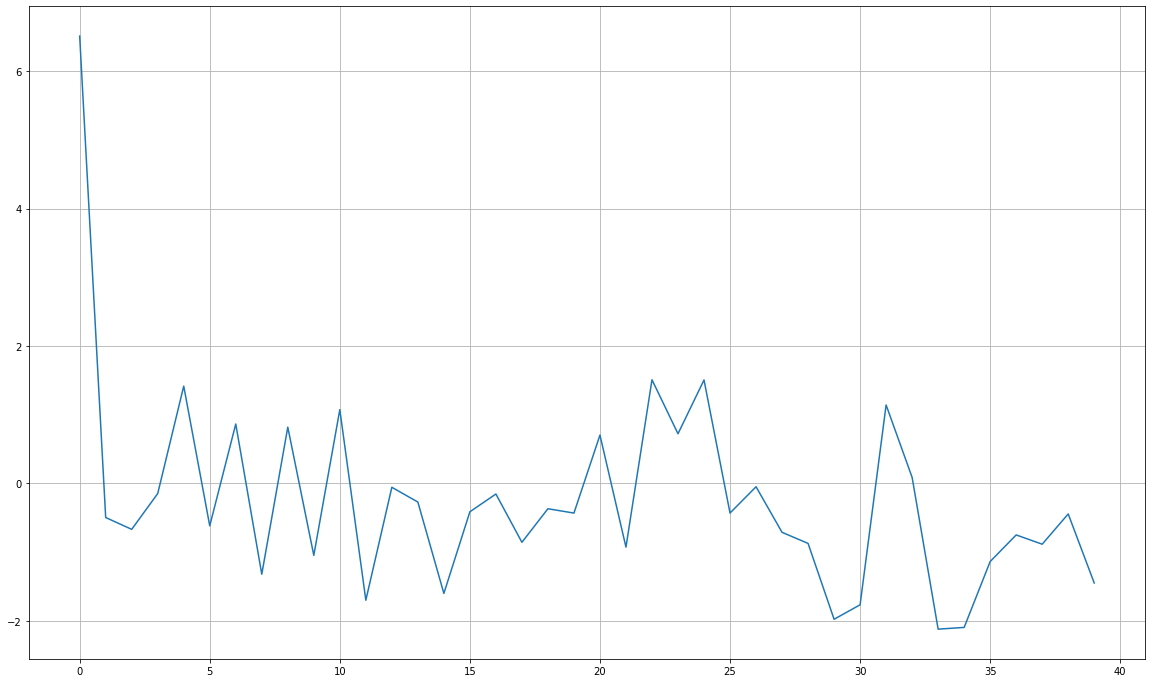

In [306]:
latency_analysis(exp_sm_forecasting, 40)